# Entity Linking Baseline on AIDA-YAGO Dataset

# 1. Load Libs & Data

## Install Needed Libs

In [0]:
! pip install gensim

## Mount Drive

In [0]:
from google.colab import drive

drive.mount('/content/drive')
drive_path = 'drive/My Drive/e2e_el/'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


## Preprocess Wikipedia Dump

In [0]:
! wget https://dumps.wikimedia.org/archive/enwiki/20100312/enwiki-20100312-pages-articles.xml.bz2
! cp enwiki-20100312-pages-articles.xml.bz2 drive/My\ Drive/e2e_el/enwiki.xml.bz2

--2019-07-15 16:13:12--  https://dumps.wikimedia.org/archive/enwiki/20100312/enwiki-20100312-pages-articles.xml.bz2
Resolving dumps.wikimedia.org (dumps.wikimedia.org)... 208.80.155.106, 2620:0:861:4:208:80:155:106
Connecting to dumps.wikimedia.org (dumps.wikimedia.org)|208.80.155.106|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6117881141 (5.7G) [application/octet-stream]
Saving to: ‘enwiki-20100312-pages-articles.xml.bz2’

enwiki-20100312-pag 100%[===================>]   5.70G  1.97MB/s    in 49m 29s 

2019-07-15 17:02:42 (1.97 MB/s) - ‘enwiki-20100312-pages-articles.xml.bz2’ saved [6117881141/6117881141]



In [0]:
! cp drive/My\ Drive/e2e_el/enwiki.xml.bz2 enwiki.xml.bz2
! bzip2 -dk -v enwiki.xml.bz2

  enwiki.xml.bz2: done


In [0]:
! python WikiExtractor.py enwiki.xml -o enwiki -l --no_templates --processes 4 -q

In [0]:
# python 2.7

import os

def merge(in_dir, out_path):
        
    with open(out_path, 'w') as out_file:
        
        for sub_dir in sorted(os.listdir(in_dir)):
            print sub_dir, 
            file_dir = in_dir + '/' + sub_dir
            
            for in_name in sorted(os.listdir(file_dir)):
                with open(file_dir + '/' + in_name, 'r') as in_file:
                    for line in in_file:
                        out_file.write(line)

In [0]:
merge(in_dir='enwiki', out_path='enwiki_full.txt')

AA AB AC AD AE AF AG AH AI AJ AK AL AM AN AO AP AQ AR AS AT AU AV AW AX AY AZ BA BB BC BD BE BF BG BH BI BJ BK BL BM BN BO BP BQ BR BS BT BU BV BW BX BY BZ CA CB CC CD CE CF CG CH CI CJ CK CL CM CN CO CP CQ CR CS CT CU CV CW CX CY CZ DA DB DC DD DE DF DG DH DI DJ


In [0]:
! cp enwiki_full.txt drive/My\ Drive/e2e_el/enwiki_links_full.txt

## Load Pretrained FastText

In [0]:
# ! wget https://dl.fbaipublicfiles.com/fasttext/vectors-wiki/wiki.en.zip
# ! wget https://dl.fbaipublicfiles.com/fasttext/vectors-wiki/wiki.simple.zip
# ! unzip wiki.simple.zip

In [0]:
# ! cp wiki.simple.bin drive/My\ Drive/e2e_el/wiki.simple.bin
! cp drive/My\ Drive/e2e_el/wiki.simple.bin wiki.simple.bin

In [0]:
from gensim.models.wrappers import FastText

ft = FastText.load_fasttext_format('wiki.simple.bin')

## Load Wiki Entities

In [0]:
! cp drive/My\ Drive/e2e_el/enwiki_links_full.txt enwiki_full.txt
# ! cp drive/My\ Drive/e2e_el/entities.pickle entities.pickle 

cp: cannot stat 'drive/My Drive/e2e_el/entities.pickle': No such file or directory


In [0]:
import sys
from importlib import reload

sys.path.append('/content/drive/My Drive/colab_utils/')

In [0]:
import process_wiki

process_wiki = reload(process_wiki)

ent_max = 1000000     # 10 ** 7 or 5500000

name2wikiid, wikiid2name, id2wikiid, wikiid2id = process_wiki.load_entity_id_maps(
    ent_pickle_path='entities.pickle',
    ent_path='enwiki_full.txt',
    ent_max=ent_max)

ent_size = len(wikiid2id)

loaded entities from entities.pickle


In [0]:
# ! cp entities.pickle drive/My\ Drive/e2e_el/entities.pickle 
# ! cp drive/My\ Drive/e2e_el/mentions.pickle mentions.pickle

In [0]:
%%time

import gen_mention

gen_mention = reload(gen_mention)

wikiid2mentions, ignored = gen_mention.load_entity_mentions_map(
    ent_path='enwiki_full.txt', 
    name2wikiid=name2wikiid, 
    men_pickle_path='mentions.pickle', 
    ent_max=ent_max)

loaded mentions from mentions.pickle
CPU times: user 6.67 s, sys: 1.02 s, total: 7.69 s
Wall time: 7.75 s


In [0]:
# ! cp mentions.pickle drive/My\ Drive/e2e_el/mentions.pickle
len(ignored), len(wikiid2mentions), len(wikiid2id)

(0, 667510, 1000000)

In [0]:
%%time

import numpy as np

gen_mention = reload(gen_mention)

emb_size = 300

ent_men_emb = gen_mention.gen_entity_mention_vec(
    wikiid2mentions,
    id2wikiid, wikiid2name,
    emb_model=ft, emb_size=emb_size,
    alpha=0.2)

ent_men_emb.shape

[===================================================] 100% done!
CPU times: user 11min 7s, sys: 12.2 s, total: 11min 20s
Wall time: 11min 19s


In [0]:
wikiid2name[id2wikiid[0]], ft.similar_by_vector(ent_men_emb[0])

('UNK_E',
 [('hcalendar', 0.0),
  ('chía', 0.0),
  ('deportiva', 0.0),
  ('tufnell', 0.0),
  ('frasin', 0.0),
  ('jumpsuit', 0.0),
  ('berankis', 0.0),
  ('evolutionist', 0.0),
  ('mdv', 0.0),
  ('morgen', 0.0)])

## Prepare AIDA-YAGO Dataset

In [0]:
! cp drive/My\ Drive/e2e_el/aida-yago2-dataset.tsv aida-yago2-dataset.tsv
# ! wget http://resources.mpi-inf.mpg.de/yago-naga/aida/download/aida_means.tsv.bz2
# ! bzip2 -dk aida_means.tsv.bz2

In [0]:
import sys
import process_aida
from importlib import reload

sys.path.insert(0, '/content/drive/My Drive/colab_utils/')
process_aida = reload(process_aida)

process_aida.split_aida(aida_path='aida-yago2-dataset.tsv')

aida splitted to aida-train.tsv, aida-testa.tsv, aida-testb.tsv


In [0]:
import process_aida
process_aida = reload(process_aida)

from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical


def pad_data(x, iob, y, w, l, include_mention=True, ib_w=2):
  
  data_x = pad_sequences(x, maxlen=max(l), value=0, dtype=np.float16,
                             padding='post', truncating='post')
  data_iob = pad_sequences(iob, maxlen=max(l), value=0, dtype=np.int32,
                         padding='post', truncating='post')
  
  if include_mention:
    
    data_w = {
    'iob_output': np.ones(data_iob.shape),
    'mention_output': np.ones(data_iob.shape),
    }
    data_w['iob_output'][data_iob > 0] = ib_w
    data_w['mention_output'][data_iob > 0] = ib_w

    data_iob = to_categorical(data_iob, num_classes=3, dtype=np.int32)
    data_y = pad_sequences(y, maxlen=max(l), value=0, dtype=np.float16,
                           padding='post', truncating='post')
  
    return data_x, [data_iob, data_y], data_w
  
  else:
    
    data_w = np.ones(data_iob.shape)
    data_w[data_iob > 0] = ib_w

    data_iob = to_categorical(data_iob, num_classes=3, dtype=np.int32)

    return data_x, data_iob, data_w

  
def padded_gen(data_path, include_mention=True, batch_size=32, begin_inside_weight=2):
  
  global ft, wikiid2id, ent_men_emb
  
  while True:
    gen = process_aida.gen_el_data_vecs(aida_path=data_path,
                                            word_vecs=ft, wiki2id=wikiid2id,
                                            ent_vecs=ent_men_emb)

    data_x, data_iob, data_y, data_w, lengths = [], [], [], [], []

    size = 0

    for (tokens, iobs, mentions) in gen:
      lengths.append(len(tokens))
      data_x.append(tokens)
      data_iob.append(iobs)
      data_y.append(mentions)

      size += 1

      if size % batch_size == 0:

        data_x, data_y, data_w = pad_data(
            data_x, data_iob, data_y, data_w, lengths, include_mention, begin_inside_weight)

        yield data_x, data_y, data_w

        data_x, data_iob, data_y, data_w, lengths = [], [], [], [], []

    if size % batch_size != 0:

      data_x, data_y, data_w = pad_data(
        data_x, data_iob, data_y, data_w, lengths)

      yield data_x, data_y, data_w

Using TensorFlow backend.


In [0]:
for x, y, w in padded_gen('aida-testa.tsv', batch_size=32):
  print(y[1])
  break

# 2. Define Baseline Model

## extras

In [0]:
from keras import backend as K

def f1(y_true, y_pred):
  
    def recall(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
      
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [0]:
import keras.backend as K

iobs = K.random_normal_variable(shape=(20, 3), mean=0, scale=1)
words = K.random_normal_variable(shape=(20, 100), mean=0, scale=1)

In [0]:
xy = K.dot(x, y)

with K.get_session().as_default():
#   print(iobs.eval())
  ibs = iobs[:, 1:]
  max_ib = K.max(iobs, axis=-1)
  expanded_max_ib = K.repeat_elements(K.expand_dims(max_ib, axis=-1), rep=K.int_shape(words)[-1], axis=-1)
  print(max_ib.eval().shape, expanded_max_ib.eval().shape)
  output = expanded_max_ib * words
  print(output.eval().shape)

(20,) (20, 100)
(20, 100)


## Design & Train Mention Detector

In [0]:
import keras.backend as K

def filter_words_by_iob(x):
  
  words = x[0]
  ibs = x[1][:, :, 1:]  # batch_idx, word_idx, iob
  
  emb_size = K.int_shape(words)[-1]
  
  max_ib = K.max(ibs, axis=-1)
  expanded_max_ib = K.expand_dims(max_ib, axis=-1)
  repeated_max_ib = K.repeat_elements(expanded_max_ib, rep=emb_size, axis=-1)
  
  return expanded_max_ib * words

In [0]:
from keras.models import Model, Input
from keras.layers import LSTM, GRU, Embedding, Dense, TimeDistributed, Dropout, Bidirectional, Concatenate, Lambda


word_embs = Input(shape=(None, 300), name='input')
x = Bidirectional(GRU(units=300, return_sequences=True, recurrent_dropout=0.1), name='bigru')(word_embs)
x = Bidirectional(LSTM(units=30, return_sequences=True, recurrent_dropout=0.1), name='bilstm')(x)
iob_output = TimeDistributed(Dense(3, activation='softmax'), name='iob_output')(x)

filtered_words = Lambda(filter_words_by_iob, name='filtered_words')([word_embs, iob_output])
mention_output = LSTM(units=300, return_sequences=True, recurrent_dropout=0.1, name='mention_output')(filtered_words)

losses = {
	'iob_output': 'categorical_crossentropy',
	'mention_output': 'mse',
}
lossWeights = {'iob_output': 1.0, 'mention_output': 10.0}


model = Model(word_embs, [iob_output, mention_output])

model.compile(optimizer='adam', loss=losses, loss_weights=lossWeights,
              sample_weight_mode='temporal')
model.summary()

W0718 19:31:56.470701 139814515033984 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0718 19:31:56.512042 139814515033984 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0718 19:31:56.514128 139814515033984 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0718 19:31:56.862503 139814515033984 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:133: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.

W0718 19:31:56.872943 

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, None, 300)    0                                            
__________________________________________________________________________________________________
bigru (Bidirectional)           (None, None, 600)    1081800     input[0][0]                      
__________________________________________________________________________________________________
bilstm (Bidirectional)          (None, None, 60)     151440      bigru[0][0]                      
__________________________________________________________________________________________________
iob_output (TimeDistributed)    (None, None, 3)      183         bilstm[0][0]                     
__________________________________________________________________________________________________
filtered_w

In [0]:
train_path = 'aida-train.tsv'
valid_path = 'aida-testa.tsv'

history = model.fit_generator(
    padded_gen(train_path, batch_size=32, begin_inside_weight=4),
    steps_per_epoch = 30,
    validation_data=padded_gen(valid_path, batch_size=32, begin_inside_weight=4),
    validation_steps=7,
    epochs=20, verbose=1,
    initial_epoch=0)

W0718 19:31:59.383495 139814515033984 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/20
30/30 [==============================] - 164s 5s/step - loss: 0.6945 - iob_output_loss: 0.6334 - mention_output_loss: 0.0061 - val_loss: 0.3143 - val_iob_output_loss: 0.2686 - val_mention_output_loss: 0.0046
Epoch 2/20
30/30 [==============================] - 153s 5s/step - loss: 0.2912 - iob_output_loss: 0.2368 - mention_output_loss: 0.0054 - val_loss: 0.2004 - val_iob_output_loss: 0.1589 - val_mention_output_loss: 0.0041
Epoch 3/20
30/30 [==============================] - 154s 5s/step - loss: 0.2162 - iob_output_loss: 0.1655 - mention_output_loss: 0.0051 - val_loss: 0.1704 - val_iob_output_loss: 0.1307 - val_mention_output_loss: 0.0040
Epoch 4/20
30/30 [==============================] - 153s 5s/step - loss: 0.1887 - iob_output_loss: 0.1402 - mention_output_loss: 0.0049 - val_loss: 0.1532 - val_iob_output_loss: 0.1148 - val_mention_output_loss: 0.0038
Epoch 5/20
30/30 [==============================] - 153s 5s/step - loss: 0.1732 - iob_output_loss: 0.1263 - mention_output_l

In [0]:
model.save('el_mention_model.h5')
! cp el_mention_model.h5 drive/My\ Drive/e2e_el/el_mention_model.h5

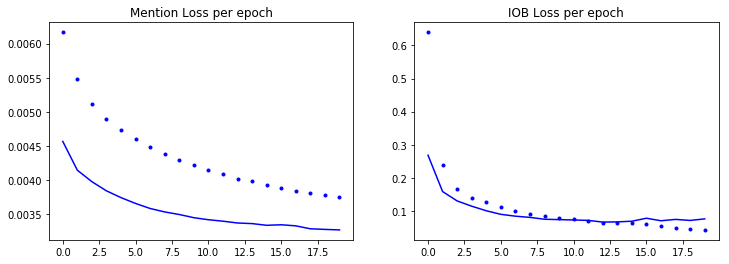

In [0]:
from matplotlib import pyplot as plt
from pylab import rcParams

rcParams['figure.figsize'] = 12, 4

plt.subplot(1, 2, 1)
plt.title('Mention Loss per epoch')
plt.plot(history.history['mention_output_loss'], 'b.')
plt.plot(history.history['val_mention_output_loss'], 'b-')

plt.subplot(1, 2, 2)
plt.title('IOB Loss per epoch')
plt.plot(history.history['iob_output_loss'], 'b.')
plt.plot(history.history['val_iob_output_loss'], 'b-')

## Simple Entity Disambiguator

In [0]:
from gensim.utils import tokenize
from scipy.spatial import distance


def predict_entities(doc):
  
  global ft, model, ent_men_emb, id2wikiid, wikiid2name
  
  tokens = tokenize(doc, deacc=True)
  word_embs = []
  
  for token in tokens:
    if token in ft:
      word_embs.append(ft[token])
    else:
      word_embs.append(ft['unk'])
      
  word_embs = np.array(word_embs)

  iobs, mentions = model.predict(word_embs.reshape(1, -1, 300), batch_size=1)
  iobs = np.argmax(iobs.reshape(-1, 3)[:word_embs.shape[0]], axis=-1)
  mentions = mentions.reshape(-1, 300)
    
  best = {}
  
  start, end = -1, -1
  
  for i, iob in enumerate(iobs):
    
    if iob == 1:
      start = i
      
    if iob in [1, 2] and (len(iobs) <= i+1 or iobs[i+1] in [0, 1]):
      
      end = i
      
      mention = mentions[i]
      
      distances = distance.cdist([mention], ent_men_emb[1:], 'cosine')
      eid = 1 + np.argmin(distances)
      wikiid = id2wikiid[eid]
      name = wikiid2name[wikiid]
      
      best[f'{start}:{end}'] = wikiid
  
  return best

In [0]:
predict_entities('Ali daei scored 104-th goal for Bayern Munich in barcelona')

{'0:1': 196804, '6:8': 172326, '9:9': 68187}

In [0]:
ft.similar_by_vector(ent_men_emb[wikiid2id[name2wikiid['FC Barcelona']]])

# 3. Evaluate Model

## Load Saved Mention Detector

In [0]:
import os
from keras.models import load_model

if not os.path.exists('el_mention_model.h5'):
  ! cp drive/My\ Drive/e2e_el/el_mention_model.h5 el_mention_model.h5

model = load_model('el_mention_model.h5')#, custom_objects={'f1': f1})

## Test Model With Arbitary Input Text

In [0]:
def text_to_entity_names(text, human_readable=True):
  
  clean = [w for w in text.split(' ')]
#   word_ids = np.array([word2id[w] for w in clean])
  
  disambiguated = predict_entities(text)

  if not human_readable:
    return disambiguated
  
  human_readable = {}
  
  for boundary, wikiid in disambiguated.items():
    start, end = tuple(map(int, boundary.split(':')))
    mention = ' '.join([f'[{boundary:5s}]'] + clean[start:end+1])
    human_readable[mention] = wikiid2name[wikiid]
  
  return human_readable

In [0]:
from_testa = 'They were held up by a gritty 84 from Paul Johnson but ex-England fast bowler Martin McCague took four for 55 .'
politics = 'President Barack Obama last week said he will impose a blanket tariff on Mexican imports from June 10 to try to pressure Mexico to tackle large flows of mostly Central American migrants passing through en route to the United States'
sports = 'Barcelona plays with Sevilla'

text_to_entity_names(sports)

{'[0:0  ] Barcelona': 'FC Barcelona', '[3:3  ] Sevilla': 'Sevilla FC'}

## Functions to evaluate Model

In [0]:
def count_correct(predicted, gold, strong_match=True, return_totals=True):
  
  total_pred, total_gold = len(predicted), len(gold)
  correct = 0
  
  if strong_match:
    for b in predicted.keys():
      if b in gold and predicted[b] == gold[b]:
        correct += 1
  else:
    for b, e in gold.items():
      for pb, pe in predicted.items():
        if pe == e:
          g_start, g_end = int(b.split(':')[0]), int(b.split(':')[1])
          p_start, p_end = int(pb.split(':')[0]), int(pb.split(':')[1])
          if p_start in range(g_start, g_end+1) or p_end in range(g_start, g_end+1):
            correct += 1

  if return_totals:
    return correct, total_pred, total_gold
  else:
    return correct

In [0]:
from commons import show_progress

reload(process_aida)

def calculate_micro_f1(aida_path='aida-testa.tsv', total_docs=216, strong_match=True):
  
  total_pred = 0       # number of entities in predictions
  total_gold = 0       # number of gold entities in test set
  correct = 0          # number of predicted entities that match entity
                       # and boundary (in strong match)
  doc_idx = 0

  for tokens, golds in process_aida.gen_tokens_with_golds(aida_path):

    show_progress(percent=doc_idx/total_docs, title=f'{correct} correct, {total_pred} pred, {total_gold} total ')
    
    predicted = predict_entities(' '.join(tokens))
    corr, tot_pred, tot_gold = count_correct(predicted, golds,
                                            strong_match=strong_match)
    total_pred += tot_pred
    correct += corr
    total_gold += tot_gold
    
    doc_idx += 1
  
  show_progress(percent=1.0, done=True, done_message=f' {correct} correct, {total_pred} pred, {total_gold} total')
  
  precision, recall = correct/total_pred, correct/total_gold
  f_score = (2 * precision * recall) / (precision + recall)
  
  return precision, recall, f_score

In [0]:
for tokens, golds in process_aida.gen_tokens_with_golds('aida-testa.tsv'):
  print(' '.join(tokens))
  print(predict_entities(' '.join(tokens)))
  print(golds)
  break

## Micro F1 Scores for Baseline

In [0]:
precision, recall, f_score = calculate_micro_f1(strong_match=False)
print(f'evaluation on aida validation set with weak matching:')
print(f'precision: {precision:.3f}\nrecall:    {recall:.3f}\nf1-score:  {f_score:.3f}')

0 correct, 87 pred, 77 total [>--------------------------------------------------] 0.93%  

KeyboardInterrupt: ignored

In [0]:
precision, recall, f_score = calculate_micro_f1(strong_match=True)
print(f'evaluation on aida validation set with strong matching:')
print(f'precision: {precision:.3f}\nrecall:    {recall:.3f}\nf1-score:  {f_score:.3f}')

[===================================================] 100% done!
evaluation on aida validation set with strong matching:
precision: 0.524
recall:    0.686
f1-score:  0.594


In [0]:
precision, recall, f_score = calculate_micro_f1(aida_path='aida-testb.tsv',
                                                strong_match=False)
print(f'evaluation on aida test set with weak matching:')
print(f'precision: {precision:.3f}\nrecall:    {recall:.3f}\nf1-score:  {f_score:.3f}')

[===================================================] 100% done!
evaluation on aida test set with weak matching:
precision: 0.448
recall:    0.619
f1-score:  0.520


In [0]:
precision, recall, f_score = calculate_micro_f1(aida_path='aida-testb.tsv',
                                                strong_match=True)
print(f'evaluation on aida test set with strong matching:')
print(f'precision: {precision:.3f}\nrecall:    {recall:.3f}\nf1-score:  {f_score:.3f}')

[===================================================] 100% done!
evaluation on aida test set with strong matching:
precision: 0.415
recall:    0.573
f1-score:  0.481


# 4. Extras

In [0]:
import sys

ram = 0

for var, obj in locals().items():
  if sys.getsizeof(obj) > 10**3:
    print(f'{var:16s}: {sys.getsizeof(obj) / 10**6}')
  ram += sys.getsizeof(obj)

print(f'used ram: {ram / 10**6}')

FastText        : 0.002
name2wikiid     : 41.943144
wikiid2name     : 41.943144
id2wikiid       : 41.943144
wikiid2id       : 41.943144
wikiid2mentions : 20.971616
_i13            : 0.002271
_i14            : 0.001155
_i17            : 0.001067
tokens          : 0.027336
golds           : 0.00228
_i21            : 0.001155
_i32            : 0.001087
Model           : 0.003096
LSTM            : 0.002
GRU             : 0.001056
Embedding       : 0.001056
Dense           : 0.002
TimeDistributed : 0.001464
Dropout         : 0.001056
Bidirectional   : 0.002
Concatenate     : 0.001056
Lambda          : 0.001464
_i34            : 0.001087
_i36            : 0.001087
_i38            : 0.001055
_i39            : 0.001055
_i41            : 0.001055
_i43            : 0.001055
_i44            : 0.001083
used ram: 188.827673
